In [81]:
#I will try to generate dr8 version of cosmos field myself
%pylab inline

import sys,os
import numpy as np
import matplotlib.pyplot as plt
from pkg_resources import resource_filename
from desiutil.log import get_logger
from desitarget import cuts
#import astropy.io.fits as pyfits
import fitsio
import healpy as hp

import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table
truth = '/global/cscratch1/sd/raichoor/desi_mcsyst/desi_mcsyst_truth.dr7.34ra38.-7dec-3.fits'
truth = fits.getdata(truth)
dat=truth

Populating the interactive namespace from numpy and matplotlib


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


(array([    464.,    1465.,    3918.,    8857.,   21421.,   61699.,
         141380.,  210077.,   71028.,   14057.]),
 array([ 18.00283432,  19.0025238 ,  20.00221329,  21.00190277,
         22.00159225,  23.00128174,  24.00097122,  25.00066071,
         26.00035019,  27.00003967,  27.99972916]),
 <a list of 10 Patch objects>)

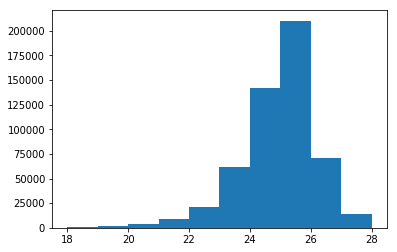

In [82]:
plt.hist(dat['g'][(dat['g']<28)&(dat['g']>18)])

In [ ]:
plt.scatter(dat['ra'],dat['dec'],c=dat['galdepth_g'],s=0.5)
plt.colorbar()

In [ ]:
colorcuts_function = cuts.isELG_colors

def mag2flux(mag) :
    return 10**(-0.4*(mag-22.5))

sel = (truth["g"]<30)&(truth["r"]<30)&(truth["z"]<30)
gflux = mag2flux(truth["g"][sel])
rflux = mag2flux(truth["r"][sel])
zflux = mag2flux(truth["z"][sel])
w1flux = np.zeros(gflux.shape)
w2flux = np.zeros(gflux.shape)

In [ ]:
sel_ELG = colorcuts_function(gflux=gflux, rflux=rflux, zflux=zflux, w1flux=w1flux, w2flux=w2flux,south=True)

In [ ]:
ELG = truth[sel][sel_ELG]

In [ ]:
p1=plt.hist(ELG['g'],alpha=0.5,bins=40,density=True,label='g')
p2=plt.hist(ELG['r'],alpha=0.5,bins=40,density=True,label='r')
p3=plt.hist(ELG['z'],alpha=0.5,bins=40,density=True,label='z')
plt.legend()
plt.title('truth ELG')

In [ ]:
def isELG_like_colors(gflux=None, rflux=None, zflux=None, w1flux=None,
                 w2flux=None, south=True, primary=None):
    """Color cuts for ELG target selection classes
    (see, e.g., :func:`~desitarget.cuts.isELG` for parameters).
    """
    lb=0.3#lb is large box south 0.3 mag larger on all selection boundries
    if primary is None:
        primary = np.ones_like(rflux, dtype='?')
    elg = primary.copy()

    # ADM cuts shared by the northern and southern selections.
    elg &= gflux < 10**((22.5-21.0+lb)/2.5)          # g>21-lb
    elg &= zflux > rflux * 10**((0.3-lb)/2.5)          # (r-z)>0.3-lb
    elg &= zflux < rflux * 10**((1.6+lb)/2.5)          # (r-z)<1.6+lb

    # ADM clip to avoid warnings from negative numbers raised to fractional powers.
    # ADM make sure to do this after the (r-z) cuts to prevent the recovery of
    # ADM very bright objects with strange colors.
    rflux = rflux.clip(0)
    zflux = zflux.clip(0)
    elg &= zflux**1.2 < gflux * rflux**0.2 * 10**((1.6+lb)/2.5)           # (g-r)<1.6+lb-1.2(r-z)

    # ADM cuts that are unique to the north or south.
    if south:
        elg &= gflux > 10**((22.5-23.45-lb)/2.5)                        # g<23.45+lb
        # ADM the south has the original FDR cut to remove stars and low-z galaxies.
        elg &= rflux**2.15 < gflux * zflux**1.15 * 10**((-0.15+lb)/2.5)   # (g-r)<1.15(r-z)-0.15+lb
    else:
        elg &= gflux > 10**((22.5-23.7-lb)/2.5)      # g<23.7+lb
        elg &= rflux > 10**((22.5-23.3-lb)/2.5)      # r<23.3+lb
        # ADM the north has a modified FDR cut to remove stars and low-z galaxies.
        elg &= rflux**2.40 < gflux * zflux**1.40 * 10**((-0.35+lb)/2.5)   # (g-r)<1.40(r-z)-0.35+lb

    return elg

In [ ]:
sel_ELG_like = isELG_like_colors(gflux=gflux, rflux=rflux, zflux=zflux, w1flux=w1flux, w2flux=w2flux,south=True)
ELG_like = truth[sel][sel_ELG_like]

In [ ]:
plt.plot(ELG_like['g']-ELG_like['r'],ELG_like['r']-ELG_like['z'],'k,')
plt.plot(ELG['g']-ELG['r'],ELG['r']-ELG['z'],'r,')
plt.xlabel('g-r')
plt.ylabel('r-z')

In [ ]:
p2=plt.hist(ELG_like['g'],alpha=0.5,bins=30,label='ELG like')
p1=plt.hist(ELG['g'],alpha=0.5,bins=30,label='ELG')
plt.legend()

In [ ]:
print('input efficiency rate:%.2f'%(len(ELG)/len(ELG_like)))

In [ ]:
len(ELG),len(ELG_like)

In [ ]:
t_ELG_like = Table(ELG_like)

In [ ]:
t_ELG_like.write('/global/cscratch1/sd/huikong/obiwan_Aug/repos_for_docker/obiwan_data/dr8/seeds.fits')
